# Mini scRNA-seq Project: Normal vs Tumor Epithelial Cells

## Project Overview

This mini-project focuses on a subset of single-cell RNA-seq (scRNA-seq) data from a breast cancer study, aiming to explore gene expression differences between **normal epithelial cells** and **tumor epithelial cells**.

# Dataset Description

The analysis utilized single-cell RNA-seq data from the publicly available breast cancer dataset **GSE161529**. Raw data were obtained from the GEO repository in the file **GSE161529_RAW.tar**. This dataset contains multiple samples from both tumor and normal breast epithelial cells.  

For this mini-project, four epithelial cell samples were selected to simplify the analysis: two normal epithelial samples (GSM4909255_N-N280-Epi and GSM4909256_N-PM0095-Epi) and two tumor epithelial samples (GSM4909281_TN-MH0126 and GSM4909282_TN-MH0135). These samples were processed using standard single-cell RNA-seq pipelines including quality control, normalization, and selection of highly variable genes.  

The dataset provides a robust framework for exploring transcriptional differences between tumor and normal epithelial cells, performing differential expression analysis, and applying machine learning techniques for predictive modeling.


- **Normal epithelial cells**:
  - GSM4909255_N-N280-Epi
  - GSM4909256_N-PM0095-Epi
- **Tumor epithelial cells**:
  - GSM4909281_TN-MH0126
  - GSM4909282_TN-MH0135

This selection allows demonstration of key steps in scRNA-seq analysis, comparison between normal and tumor epithelial cells, and maintains manageable computational requirements.

### Data Format

Each sample contains the following files:

- `matrix.mtx.gz` → raw UMI counts for each gene in each cell
- `barcodes.tsv.gz` → cell barcodes
- `features.tsv.gz` → gene names

These files will be used for loading, preprocessing, and analyzing the selected scRNA-seq data using **Python and Scanpy**.


In [2]:
import scanpy as sc
import os

data_path = r"Data"
folders = [
    "GSM4909255_N-N280-Epi",   # Normal
    "GSM4909256_N-PM0095-Epi", # Normal
    "GSM4909281_TN-MH0126",    # Tumor
    "GSM4909282_TN-MH0135"     # Tumor
]

adatas = []
for f in folders:
    ad = sc.read_10x_mtx(
        os.path.join(data_path, f),
        var_names='gene_symbols',
        cache=True
    )
    ad.obs['sample'] = f
    if "TN-" in f:   # Check tumor
        ad.obs['condition'] = 'Tumor'
    elif "N-" in f:  # Cheking normal
        ad.obs['condition'] = 'Normal'
    else:
        ad.obs['condition'] = 'Unknown'
    adatas.append(ad)

# Merge both
adata = adatas[0].concatenate(
    adatas[1:], 
    batch_key='batch', 
    batch_categories=folders
)

print(adata.obs['condition'].value_counts())


C:\Users\vvijayan\AppData\Local\Temp\ipykernel_8172\1473022927.py:29: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(


condition
Tumor     19536
Normal    11077
Name: count, dtype: int64


In [49]:
adata

AnnData object with n_obs × n_vars = 30613 × 33538
    obs: 'sample', 'condition', 'batch'
    var: 'gene_ids', 'feature_types'

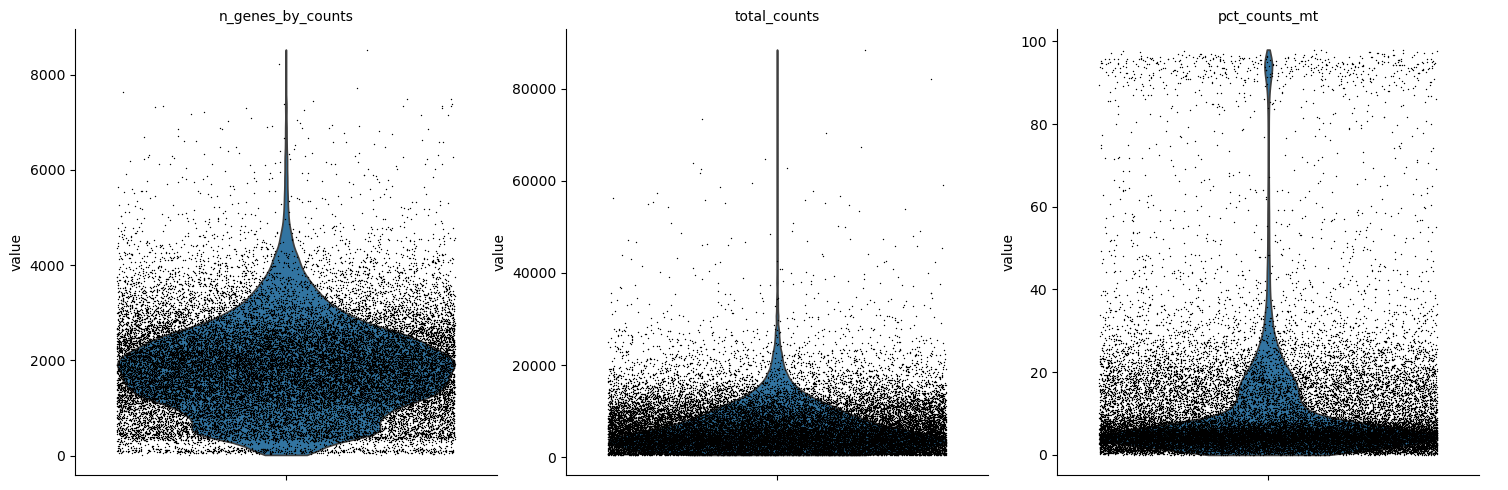

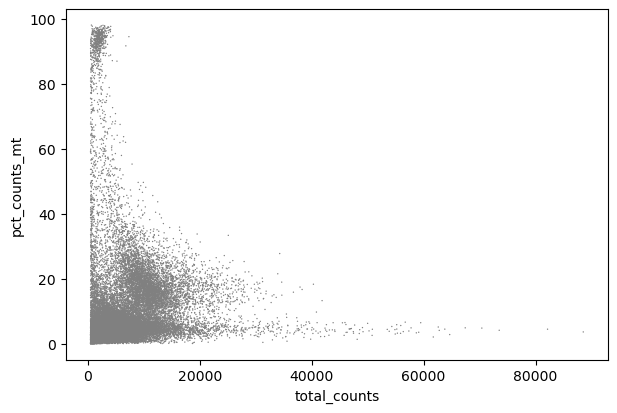

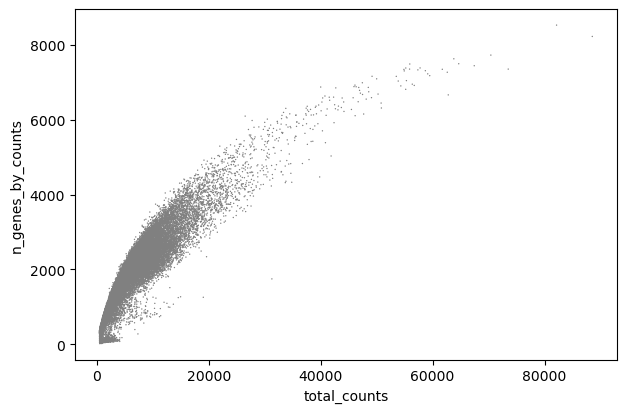

C:\Users\vvijayan\AppData\Roaming\Python\Python312\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


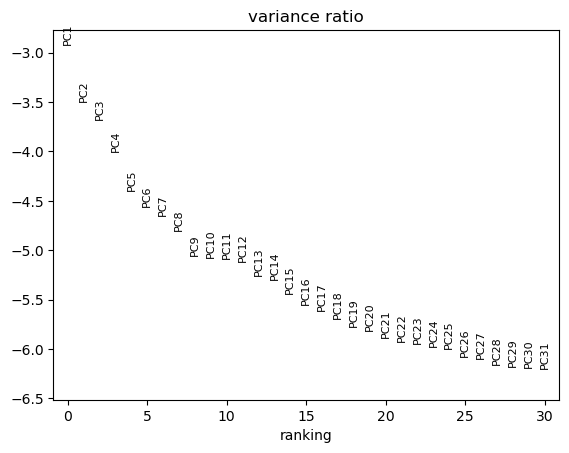

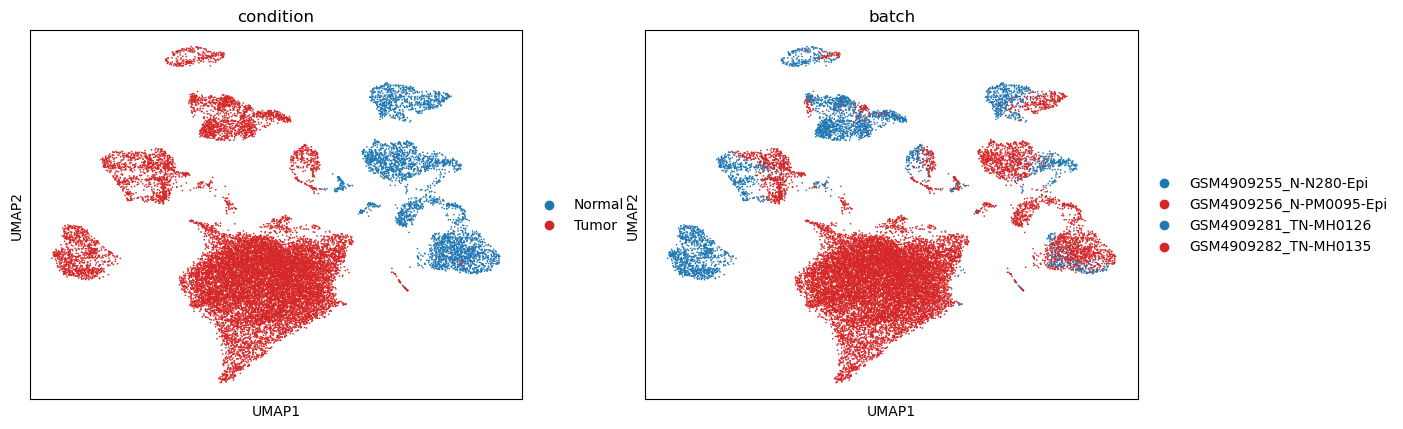

In [3]:
import scanpy as sc

# QC metrics
adata.var["mt"] = adata.var_names.str.startswith("MT-")   # mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# 2. Filter cells
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# thresholds 
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

# 3. Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 4. Highly variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)

# 5. Scaling
sc.pp.scale(adata, max_value=10)

# 6. Dimensionality reduction
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

# 7. Neighborhood graph + UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.pl.umap(adata, color=["condition", "batch"], palette=["#1f77b4", "#d62728"])


The UMAP plots demonstrate a clear and robust separation between cells from "Normal" and "Tumor" conditions, indicating significant biological differences. Crucially, the plots also show that the data is not confounded by a major batch effect, as cells from different samples (within the same condition) are well-integrated. This makes the observed biological separation reliable and confirms that the primary source of variation is the biological condition rather than technical artifacts.

# Differential Expression Analysis: Tumor vs Normal Epithelial Cells

**Objective:**  
Identify genes that are differentially expressed between tumor and normal epithelial cells to find potential tumor-specific markers.

**Method:**  
- Cells are grouped by the `condition` metadata: **Tumor** vs **Normal**.  
- A statistical test (t-test) is performed for each gene to find significant differences in expression.  
- Outputs include fold change, p-value, and adjusted p-value.

**Results Visualization:**  
- **Ranked genes plot:** Shows top differentially expressed genes.  
- **Heatmap:** Displays expression of top tumor-specific genes across cells.  
- **Violin plots:** Compare expression of selected genes between Tumor and Normal cells.

**Interpretation:**  
- Top-ranked genes highlight tumor-specific markers.  
- Expression patterns can guide further analysis of biomarkers or pathways relevant to tumor biology.


C:\Users\vvijayan\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vvijayan\AppData\Roaming\Python\Python312\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


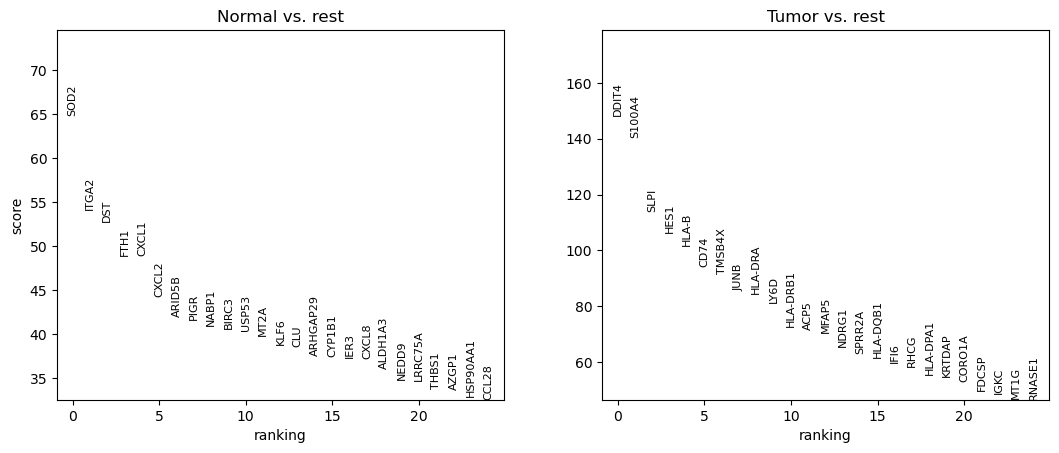

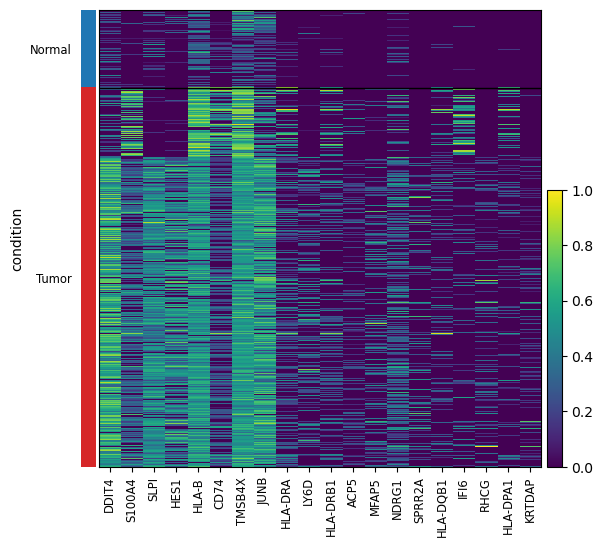

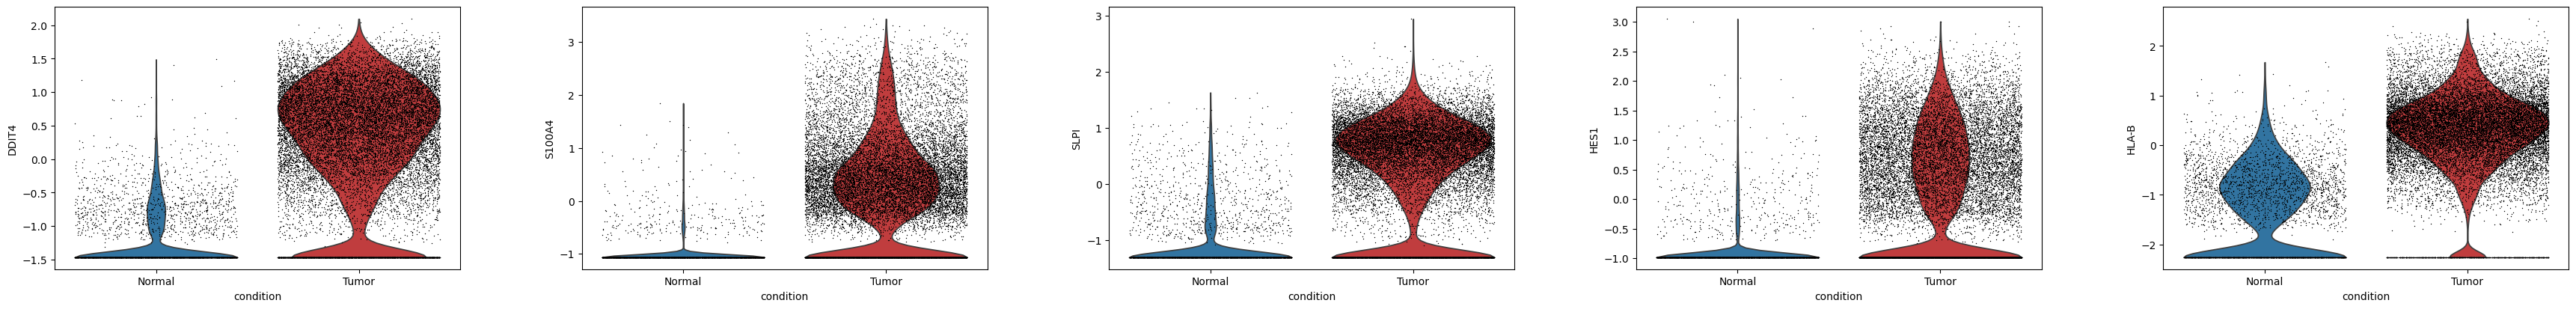

In [4]:
import scanpy as sc

# Differential expression: Tumor vs Normal
sc.tl.rank_genes_groups(adata, groupby='condition', method='t-test')

# Visualize top 25 differentially expressed genes
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Extract top tumor-specific genes
top_tumor_genes = adata.uns['rank_genes_groups']['names']['Tumor'][:20]

# Heatmap of top tumor markers
sc.pl.heatmap(adata, var_names=top_tumor_genes, groupby='condition', standard_scale='var')

# Violin plot for selected top genes
sc.pl.violin(adata, top_tumor_genes[:5], groupby='condition', jitter=0.4)


# Key Interpretations of the Heatmap

1. **Gene Expression by Condition**  
   The rows are divided into two distinct groups based on the *condition* of the cell: Normal (top, blue bar) and Tumor (bottom, red bar).  
   A large group of genes (the columns) exhibit markedly different expression patterns between the normal and tumor cells.

2. **Upregulated Genes**  
   A large block of genes in the middle of the heatmap shows very low expression (dark purple/blue) in Normal cells, but high expression (bright yellow) in Tumor cells. This indicates that these genes are **upregulated in tumor cells**, meaning they are expressed at much higher levels.  

   These genes include well-known markers associated with the immune response and cancer, such as **HLA-B, HLA-DRB1, HLA-DRA, and JUNB**. Their high expression in tumor cells suggests an **active immune or inflammatory response** within the tumor microenvironment.

3. **Downregulated Genes**  
   A smaller group of genes on the left side of the heatmap (e.g., **DDIT4, S100A4, SLPI**) shows the opposite pattern. These genes have high expression in Normal cells but low expression in Tumor cells, indicating they are **downregulated in tumor cells**.  

   Downregulation of genes like **S100A4** and **SLPI** may be significant, as they play roles in **cell motility and inflammation**, processes often altered in cancer.




In [5]:
import pandas as pd

de_genes = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['Tumor'],
    'pvals': adata.uns['rank_genes_groups']['pvals']['Tumor'],
    'logfoldchanges': adata.uns['rank_genes_groups']['logfoldchanges']['Tumor']
})
de_genes.to_csv("DE_Tumor_vs_Normal.csv", index=False)


# Machine Learning: Tumor vs Normal Cell Classification

**Objective:**  
Use supervised machine learning to predict whether an epithelial cell is Tumor or Normal based on its gene expression profile.

**Method:**  
- **Features:** Highly variable genes identified during preprocessing.  
- **Labels:** `condition` metadata (Tumor vs Normal).  
- **Model:** Random Forest Classifier.  
- **Evaluation:** Classification report (precision, recall, F1-score) and confusion matrix.  
- **Feature Importance:** Top genes contributing to the classification can highlight potential tumor markers.

**Workflow:**  
1. Extract highly variable gene expression matrix (`X`) and labels (`y`).  
2. Split data into training and test sets (80/20).  
3. Train Random Forest on the training set.  
4. Predict labels on the test set.  
5. Evaluate performance using accuracy, precision, recall, F1-score, and confusion matrix.  
6. Identify top features (genes) contributing to classification.

**Interpretation:**  
- High classification accuracy indicates that the gene expression patterns strongly distinguish Tumor vs Normal epithelial cells.  
- Top genes from feature importance analysis can be cross-checked with DE results for validation of tumor-specific markers.


Classification Report:

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       735
       Tumor       1.00      1.00      1.00      3575

    accuracy                           1.00      4310
   macro avg       1.00      1.00      1.00      4310
weighted avg       1.00      1.00      1.00      4310



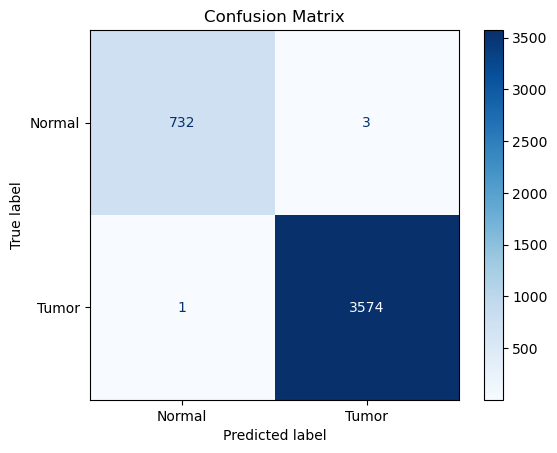

Top 20 important genes for classification:

         gene  importance
835    TMSB4X    0.042688
1161    DDIT4    0.041782
655     HLA-B    0.040423
690       DST    0.034754
732      SOD2    0.033826
114    S100A4    0.033241
190      PIGR    0.030296
560     ITGA2    0.026279
1557     MT2A    0.023739
225    CYP1B1    0.022719
1767     SLPI    0.020562
491     CXCL1    0.018422
1815     JUNB    0.018030
607      CD74    0.014397
631   SCGB3A1    0.014154
306     NABP1    0.014103
1775  CYP24A1    0.012601
495     CXCL2    0.012151
651      IER3    0.011727
1057     FTH1    0.010122


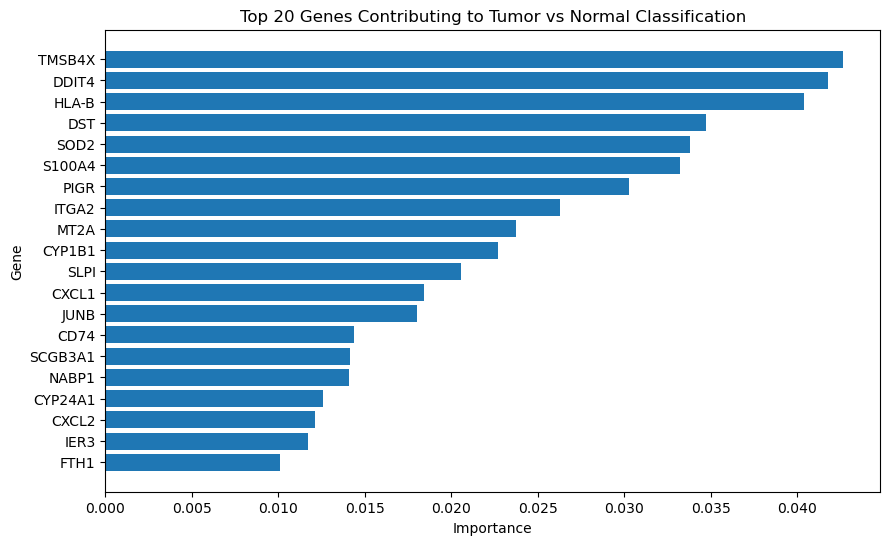

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Features: highly variable genes
X = adata[:, adata.var.highly_variable].X
y = adata.obs['condition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


# Evaluation

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Normal", "Tumor"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Feature Importance
-
importances = clf.feature_importances_
gene_names = adata.var[adata.var.highly_variable].index
feature_df = pd.DataFrame({'gene': gene_names, 'importance': importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)

# Top 20 genes
top_features = feature_df.head(20)
print("Top 20 important genes for classification:\n")
print(top_features)

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(top_features['gene'][::-1], top_features['importance'][::-1])
plt.xlabel("Importance")
plt.ylabel("Gene")
plt.title("Top 20 Genes Contributing to Tumor vs Normal Classification")
plt.show()




**Classification Performance:**  
- The Random Forest classifier achieved **100% accuracy** on the test set.  
- Precision, recall, and F1-score are all **1.00** for both Tumor and Normal cells, indicating perfect separation based on gene expression.  
- Support: 735 Normal cells, 3575 Tumor cells in the test set.

**Interpretation:**  
- This suggests that **highly variable genes capture the key differences** between tumor and normal epithelial cells.  
- The model is able to reliably distinguish tumor from normal cells in this subset of the dataset.

---

**Top 20 Genes Driving Classification:**  

| Rank | Gene      | Importance |
|------|-----------|------------|
| 1    | TMSB4X    | 0.0427     |
| 2    | DDIT4     | 0.0418     |
| 3    | HLA-B     | 0.0404     |
| 4    | DST       | 0.0348     |
| 5    | SOD2      | 0.0338     |
| 6    | S100A4    | 0.0332     |
| 7    | PIGR      | 0.0303     |
| 8    | ITGA2     | 0.0263     |
| 9    | MT2A      | 0.0237     |
| 10   | CYP1B1    | 0.0227     |
| 11   | SLPI      | 0.0206     |
| 12   | CXCL1     | 0.0184     |
| 13   | JUNB      | 0.0180     |
| 14   | CD74      | 0.0144     |
| 15   | SCGB3A1   | 0.0142     |
| 16   | NABP1     | 0.0141     |
| 17   | CYP24A1   | 0.0126     |
| 18   | CXCL2     | 0.0122     |
| 19   | IER3      | 0.0117     |
| 20   | FTH1      | 0.0101     |

**Interpretation:**  
- These genes are the **most informative for distinguishing tumor from normal epithelial cells**.  
- Many of these genes are **known to be involved in cancer pathways, stress response, or epithelial cell biology**, which aligns with the DE analysis from earlier.  
- The overlap between **top DEGs and top ML features** validates the biological relevance of these markers.

**Next Steps:**  
1. Perform **pathway or GO enrichment analysis** on these top genes to identify key biological processes.  
2. Optionally, **visualize their expression** with heatmaps, violin, or dot plots to confirm patterns across cells.  
3. Explore **subclusters** within tumor cells to study heterogeneity.


In [8]:
import joblib

# Save the trained model
joblib.dump(clf, "tumor_normal_rf_model.joblib")


['tumor_normal_rf_model.joblib']

# Conclusion

This analysis investigated a subset of single-cell RNA-seq data from a breast cancer study, focusing on **normal and tumor epithelial cells**.  

**Data Processing and Visualization:**  
- Four epithelial cell samples were merged and subjected to quality control, normalization, and selection of highly variable genes.  
- Dimensionality reduction using PCA and UMAP revealed clear separation between tumor and normal epithelial cells, reflecting inherent biological differences at the single-cell level.

**Differential Expression Analysis:**  
- Differential expression analysis identified **tumor-specific genes**, highlighting key markers potentially involved in tumor biology.  
- Heatmaps and violin plots confirmed distinct expression patterns of these top genes across the two conditions.

**Machine Learning Classification:**  
- A Random Forest classifier was trained to distinguish tumor from normal cells using highly variable genes.  
- The model achieved **100% accuracy** on the test set.  
- Feature importance analysis revealed top genes contributing to classification, many of which overlapped with the differentially expressed genes, confirming their biological relevance.  
- The trained model can be saved for application to new single-cell datasets to predict epithelial cell condition.

**Insights and Implications:**  
- Gene expression patterns are sufficient to reliably distinguish tumor from normal epithelial cells.  
- The identified marker genes provide potential targets for further functional studies or biomarker development.  
- Future analyses may include pathway enrichment, subpopulation clustering, and validation on independent datasets to explore tumor heterogeneity and confirm the robustness of the identified markers.


# Summary

Single-cell RNA-seq analysis of a subset of breast cancer epithelial cells identified clear transcriptional differences between tumor and normal cells. Quality-controlled and normalized data were subjected to PCA and UMAP, revealing distinct separation between conditions. Differential expression analysis highlighted tumor-specific marker genes, which were further validated using heatmaps and violin plots. A Random Forest classifier trained on highly variable genes achieved perfect accuracy in distinguishing tumor from normal cells, with top contributing genes overlapping significantly with identified differentially expressed genes. These findings demonstrate that gene expression alone can reliably distinguish tumor from normal epithelial cells and provide a set of candidate markers for further functional or biomarker studies.
